 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.05224494264597794
       x: [ 3.464e-01  5.735e-01  1.940e+00  9.988e-01]
     nit: 86
     jac: [-4.813e-03  3.661e-03  1.329e-03 -4.476e-02]
    nfev: 466
    njev: 86


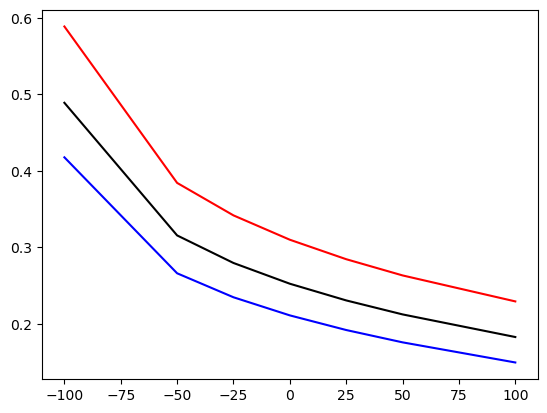

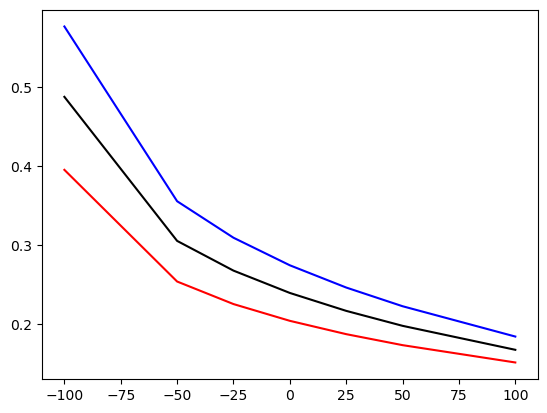

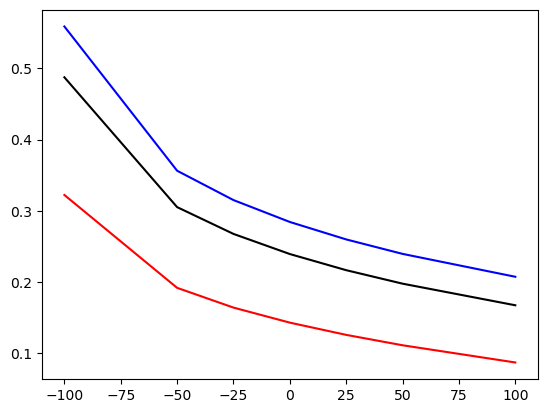

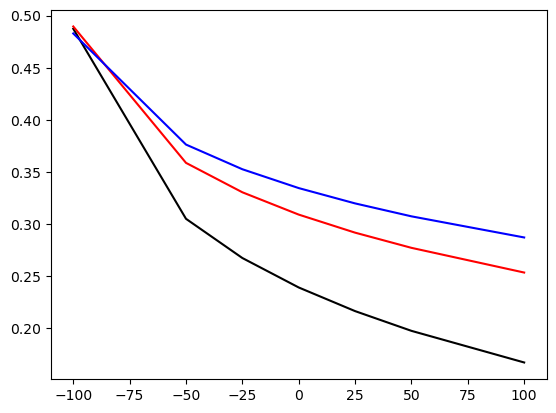

In [67]:
import numpy as np
import pandas as pd
import QuantLib as ql
from matplotlib import pyplot as plt
from scipy import optimize

# Parameters from the post
strikes = [-100, -50, -25, 0, 25, 50, 100]
vols = [1.047, 0.4812, 0.4327, 0.4268, 0.4148, 0.4253, 0.4322]

fwd = 0.035
expiry = 0.25
shift = 0.0110 # Shift chosen to make first strike positive

# params are sigma_0, beta, vol_vol, rho
params = [0.2, 0.6, 0.3, -0.4]

# Optimise SABR least squares using python's minimize function
def f(params):
    alpha, beta, nu, rho = params[0], params[1], params[2], params[3]

    alpha = max(alpha, 1e-8) # Avoid alpha going negative
    beta = max(beta, 1e-8) # Avoid beta going negative
    nu = max(nu, 1e-8) # Avoid nu going negative
    rho = max(rho, -0.999) # Avoid rhp going < -1.0
    rho = min(rho, 0.999) # Avoid rho going > 1.0

    calc_vols = np.array([
        ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
        for strike in strikes
    ])

    error = ((calc_vols - np.array(vols))**2 ).mean() **.5
    return error

cons = (
    {'type': 'ineq', 'fun': lambda x: x[0]},
    {'type': 'ineq', 'fun': lambda x: 0.99 - x[1]},
    {'type': 'ineq', 'fun': lambda x: x[1]},
    {'type': 'ineq', 'fun': lambda x: x[2]},
    {'type': 'ineq', 'fun': lambda x: 1. - x[3]**2}
)

result = optimize.minimize(f, params, constraints=cons, options={'eps': 1e-5})
alpha, beta, nu, rho = result['x'][0], result['x'][1], result['x'][2], result['x'][3]

calc_vols = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])

results = pd.DataFrame([vols, calc_vols], columns=strikes, index=['market', 'SABR'])
print(result)

# Beta shift
fwd = 0.035
alpha = 0.03
beta = 0.6
beta_ = 0.5
beta_1 = 0.7
nu= 0.3
rho =-0.3
expiry = 1
calc_vols = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
calc_vols_ = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta_, nu, rho)
    for strike in strikes
])
calc_vols_1 = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta_1, nu, rho)
    for strike in strikes
])
plt.plot(strikes,calc_vols, c = 'black')
plt.plot(strikes,calc_vols_ ,c= 'r')
plt.plot(strikes,calc_vols_1, c='b')
plt.show()
calc_vols_1
# nu shift
fwd = 0.025
alpha = 0.03
beta = 0.6
nu= 0.3
nu_ = 0.2
nu_1 = 0.4
rho =-0.3
expiry = 1
calc_vols = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
calc_vols_ = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu_, rho)
    for strike in strikes
])
calc_vols_1 = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu_1, rho)
    for strike in strikes
])
plt.plot(strikes,calc_vols, c = 'black')
plt.plot(strikes,calc_vols_ ,c= 'r')
plt.plot(strikes,calc_vols_1, c='b')
plt.show()
# alpha shift
fwd = 0.025
alpha = 0.03
alpha_ = 0.01
alpha_1 = 0.04
beta = 0.6
nu= 0.3

rho =-0.3
expiry = 1
calc_vols = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
calc_vols_ = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha_, beta, nu, rho)
    for strike in strikes
])
calc_vols_1 = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha_1, beta, nu, rho)
    for strike in strikes
])
plt.plot(strikes,calc_vols, c = 'black')
plt.plot(strikes,calc_vols_ ,c= 'r')
plt.plot(strikes,calc_vols_1, c='b')
plt.show()
# forward rate shift
fwd = 0.025
fwd_ = 0.15
fwd_1 = 0.35
alpha = 0.03
beta = 0.6
nu= 0.3

rho =-0.3
expiry = 1
calc_vols = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
calc_vols_ = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd_ + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
calc_vols_1 = np.array([
    ql.sabrVolatility(strike*1e-4 + shift, fwd_1 + shift, expiry, alpha, beta, nu, rho)
    for strike in strikes
])
plt.plot(strikes,calc_vols, c = 'black')
plt.plot(strikes,calc_vols_ ,c= 'r')
plt.plot(strikes,calc_vols_1, c='b')
plt.show()